In [7]:
import pandas as pd
import numpy as np

In [8]:
df = pd.read_csv('error_analysis_results.csv')
df.head()

,text,label,labels,original_index,predicted_label,predicted_numeric,confidence,correct,prob_neutral,prob_positive,prob_negative
0,3 Perceptron Training The parsing problem is t...,o,0,0,o,0,0.921852,True,0.921852,0.066441,0.011707
1,"In Table 6 we report our results, together wit...",o,0,1,p,1,0.641797,False,0.339030,0.641797,0.019174
2,"(2006) produced a corpus of 4,000 questions an...",n,2,2,o,0,0.710933,False,0.710933,0.249927,0.039141
3,Our corpora were automatically aligned with Gi...,o,0,3,o,0,0.956838,True,0.956838,0.039636,0.003526
4,"In this work, we propose two models that can b...",p,1,4,p,1,0.612680,True,0.335229,0.612680,0.052091


In [9]:
# Phase 1: Data Preparation & Annotation Schema
import re
from collections import Counter
errors_df = df[df['label'] != df['predicted_label']].copy()
print(f"Total errors: {len(errors_df)} (out of {len(df)} samples) -> {len(errors_df)/len(df)*100:.1f}% error rate")

# 1. error_type (e.g., negative_as_positive)
label_map_verbose = {'n':'negative','o':'neutral','p':'positive'}
errors_df['true_label_verbose'] = errors_df['label'].map(label_map_verbose)
errors_df['pred_label_verbose'] = errors_df['predicted_label'].map(label_map_verbose)
errors_df['error_type'] = errors_df['true_label_verbose'] + '_as_' + errors_df['pred_label_verbose']

# 2. context_length_words
errors_df['context_length_words'] = errors_df['text'].apply(lambda x: len(str(x).split()))

# 3. Surface cue detectors (binary features)
hedging_terms = set(['may','might','could','would','seems','appears','suggests','possibly','probably','perhaps','likely','potentially','tend'])
contrastive_terms = set(['however','but','although','though','while','whereas','in contrast','on the other hand','nevertheless','nonetheless'])
positive_eval_terms = set(['improves','improved','improving','effective','robust','state-of-the-art','significant improvement','better','superior','outperforms','achieves','achieved','demonstrates','demonstrated','strong'])
negative_eval_terms = set(['fails','failed','failing','limitation','limitations','drawback','drawbacks','inconsistent','error-prone','poor','worse','underperforms','weak','insufficient','lacks','lack'])
metric_terms = set(['bleu','rouge','f1','accuracy','auc','precision','recall','meteor','ter','nist','per','cer','wer','macro-f1','micro-f1'])

def binary_flag(text, vocab):
    tl = text.lower()
    return int(any(term in tl for term in vocab))

def multi_citation_flag(text):
    paren = re.findall(r'\(([^)]{0,120})\)', text)
    citation_like = 0
    for p in paren:
        if re.search(r'\b(19|20)\d{2}\b', p):
            citation_like += 1
    if any(';' in p for p in paren):
        return 1
    return 1 if citation_like >= 2 else 0

errors_df['cue_hedging'] = errors_df['text'].apply(lambda t: binary_flag(t, hedging_terms))
errors_df['cue_contrastive'] = errors_df['text'].apply(lambda t: binary_flag(t, contrastive_terms))
errors_df['cue_positive_eval'] = errors_df['text'].apply(lambda t: binary_flag(t, positive_eval_terms))
errors_df['cue_negative_eval'] = errors_df['text'].apply(lambda t: binary_flag(t, negative_eval_terms))
errors_df['cue_metric'] = errors_df['text'].apply(lambda t: binary_flag(t, metric_terms))
errors_df['cue_multi_citation'] = errors_df['text'].apply(multi_citation_flag)

# 4. Lightweight intent classification (rule-based)
intent_patterns = {
    'Background': ['previous work','prior work','earlier work','as described','as discussed','related work','see also','following','based on','according to'],
    'Method': ['we use','we adopt','we apply','we employ','using the','using a','method','approach','model','framework','algorithm'],
    'Result/Comparison': ['outperforms','better than','compared to','versus','state-of-the-art','competitive','achieves','higher than','lower than','improves over'],
    'Weakness/Limitation': ['fails','limitation','drawback','weakness','cannot','unable','insufficient','problem','issue','challenge'],
    'Other': []
}

def classify_intent(text):
    tl = text.lower()
    scores = {k:0 for k in intent_patterns}
    for intent, pats in intent_patterns.items():
        for p in pats:
            if p in tl:
                scores[intent] += 1
    best_intent = max(scores.items(), key=lambda kv: kv[1])[0]
    if scores[best_intent] == 0:
        return 'Background'
    return best_intent

errors_df['intent'] = errors_df['text'].apply(classify_intent)

# One-hot encode intent
for intent_label in ['Background','Method','Result/Comparison','Weakness/Limitation','Other']:
    col = 'intent_' + intent_label.replace('/','_').replace(' ','_')
    errors_df[col] = (errors_df['intent'] == intent_label).astype(int)

# 5. document_section now mirrors intent (per user request)
errors_df['document_section'] = errors_df['intent']
errors_df['error_reason_tags'] = ''  # placeholder for later manual tags

print('Enriched columns added:')
print([c for c in errors_df.columns if c not in ['label','predicted_label']][:25])
errors_df.head(3)

Total errors: 239 (out of 1596 samples) -> 15.0% error rate
Enriched columns added:
['text', 'labels', 'original_index', 'predicted_numeric', 'confidence', 'correct', 'prob_neutral', 'prob_positive', 'prob_negative', 'true_label_verbose', 'pred_label_verbose', 'error_type', 'context_length_words', 'cue_hedging', 'cue_contrastive', 'cue_positive_eval', 'cue_negative_eval', 'cue_metric', 'cue_multi_citation', 'intent', 'intent_Background', 'intent_Method', 'intent_Result_Comparison', 'intent_Weakness_Limitation', 'intent_Other']


,text,label,labels,original_index,predicted_label,predicted_numeric,confidence,correct,prob_neutral,prob_positive,...,cue_metric,cue_multi_citation,intent,intent_Background,intent_Method,intent_Result_Comparison,intent_Weakness_Limitation,intent_Other,document_section,error_reason_tags
1,"In Table 6 we report our results, together wit...",o,0,1,p,1,0.641797,False,0.339030,0.641797,...,0,0,Result/Comparison,0,0,1,0,0,Result/Comparison,
2,"(2006) produced a corpus of 4,000 questions an...",n,2,2,o,0,0.710933,False,0.710933,0.249927,...,1,1,Method,0,1,0,0,0,Method,
6,"However, these unsupervised methodologies show...",o,0,6,n,2,0.617735,False,0.276066,0.106199,...,1,1,Method,0,1,0,0,0,Method,


## Phase 2: Quantitative Analysis (Foundational Metrics)

This phase focuses ONLY on high-level statistical patterns to prioritize where to inspect qualitatively later (no deep tagging logic yet):

1. General Error Distribution
   - Confusion matrix across all predictions (to see if 'neutral' is over-predicted).
   - Frequency of each `error_type` (e.g., negative_as_neutral, positive_as_neutral, etc.).

2. Impact of Document Section (Preliminary)
   - If `document_section` is not yet annotated, rows will be marked as blank or 'UNKNOWN'.
   - Counts of errors per section (once filled) and proportional contribution.
   - (Optional later) Section accuracy requires total counts (errors + correct) per section.

3. Impact of Sentence Length
   - Length distribution: errors vs correct (if correct set available here).
   - Histogram / basic stats of `context_length_words`.
   - Mean length by (future) `document_section` for error rows.

Output from this phase will guide Phase 3 (Qualitative deep dive).

Total errors: 239
Sample columns: ['citation_context', 'true_label_code', 'labels', 'original_index', 'predicted_label_code', 'predicted_numeric', 'confidence', 'correct', 'prob_neutral', 'prob_positive', 'prob_negative', 'true_label_verbose', 'pred_label_verbose', 'error_type', 'context_length_words']


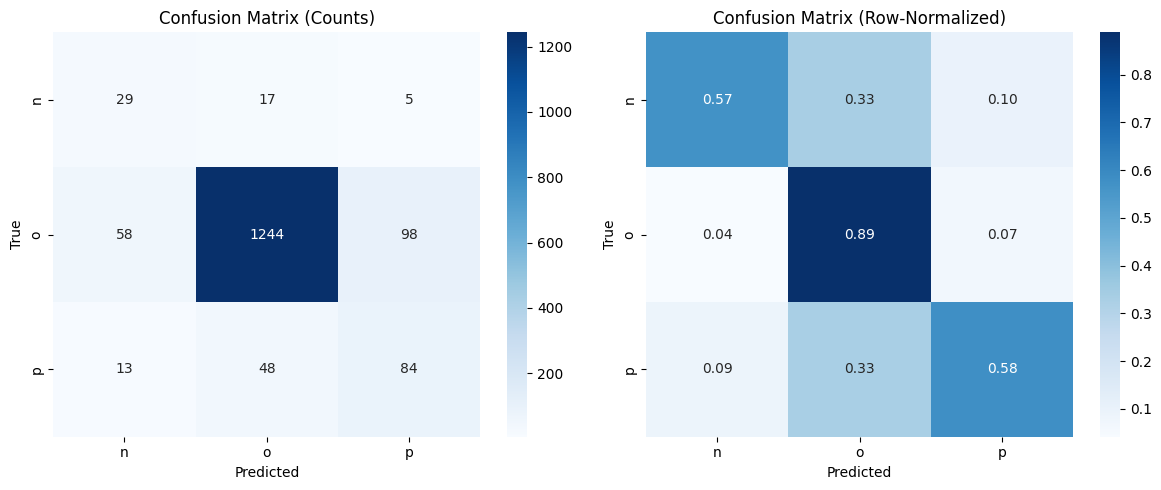

True neutral count: 1400
Predicted neutral count: 1309
Neutral overprediction delta: -91 (positive => over-predicted)

Top error types:
             error_type  count        pct
0   neutral_as_positive     98  41.004184
1   neutral_as_negative     58  24.267782
2   positive_as_neutral     48  20.083682
3   negative_as_neutral     17   7.112971
4  positive_as_negative     13   5.439331
5  negative_as_positive      5   2.092050


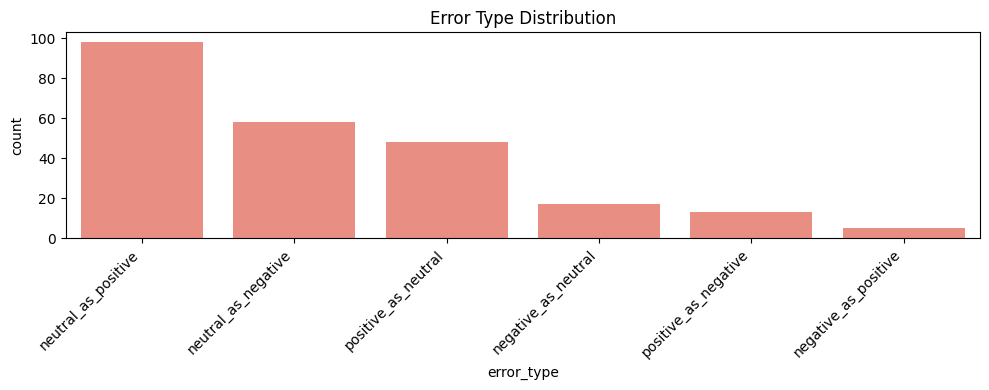

In [10]:
# Phase 2 Step 1: General Error Distribution
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import seaborn as sns

# Build master error sheet (subset)
master_errors = errors_df.copy()

# Ensure required columns exist / align naming to spec
master_errors = master_errors.rename(columns={
    'text':'citation_context',
    'label':'true_label_code',
    'predicted_label':'predicted_label_code'
})

# Verbose already created: true_label_verbose, pred_label_verbose
# error_type already created

print(f"Total errors: {len(master_errors)}")
print("Sample columns:", master_errors.columns.tolist()[:15])

# Confusion matrix on full df (not just errors)
labels_order = ['n','o','p']
cm = confusion_matrix(df['label'], df['predicted_label'], labels=labels_order)
fig, ax = plt.subplots(1,2, figsize=(12,5))

sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels_order, yticklabels=labels_order, ax=ax[0])
ax[0].set_title('Confusion Matrix (Counts)')
ax[0].set_xlabel('Predicted')
ax[0].set_ylabel('True')

cm_norm = cm / cm.sum(axis=1, keepdims=True)
sns.heatmap(cm_norm, annot=True, fmt='.2f', cmap='Blues', xticklabels=labels_order, yticklabels=labels_order, ax=ax[1])
ax[1].set_title('Confusion Matrix (Row-Normalized)')
ax[1].set_xlabel('Predicted')
ax[1].set_ylabel('True')
plt.tight_layout()
plt.show()

# Neutral over-prediction check
true_neutral = (df['label']=='o').sum()
pred_neutral = (df['predicted_label']=='o').sum()
print(f"True neutral count: {true_neutral}")
print(f"Predicted neutral count: {pred_neutral}")
print(f"Neutral overprediction delta: {pred_neutral - true_neutral} (positive => over-predicted)")

# error_type distribution
err_counts = master_errors['error_type'].value_counts().reset_index()
err_counts.columns = ['error_type','count']
err_counts['pct'] = err_counts['count'] / len(master_errors) * 100
print("\nTop error types:")
print(err_counts.head(10))

plt.figure(figsize=(10,4))
sns.barplot(data=err_counts, x='error_type', y='count', color='salmon')
plt.xticks(rotation=45, ha='right')
plt.title('Error Type Distribution')
plt.xlabel('error_type')
plt.ylabel('count')
plt.tight_layout()
plt.show()

Error counts by document_section (mirrors intent):
      document_section  error_count  pct_of_errors
0           Background          110      46.025105
1               Method           99      41.422594
3  Weakness/Limitation           24      10.041841
2    Result/Comparison            6       2.510460


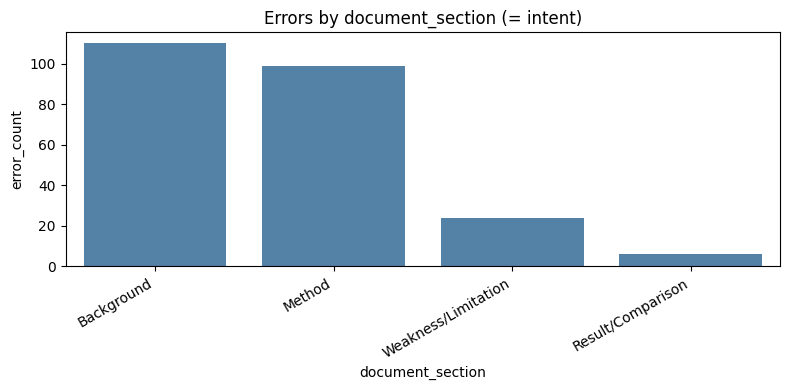

In [11]:
# Phase 2 Step 2: Impact of Document Section (document_section = intent)
# Since document_section mirrors intent, this is effectively intent distribution within errors.
section_err_counts = master_errors.groupby('document_section').size().reset_index(name='error_count')
section_err_counts['pct_of_errors'] = section_err_counts['error_count']/len(master_errors)*100
print("Error counts by document_section (mirrors intent):")
print(section_err_counts.sort_values('error_count', ascending=False))

plt.figure(figsize=(8,4))
sns.barplot(data=section_err_counts.sort_values('error_count', ascending=False), x='document_section', y='error_count', color='steelblue')
plt.title('Errors by document_section (= intent)')
plt.xticks(rotation=30, ha='right')
plt.ylabel('error_count')
plt.xlabel('document_section')
plt.tight_layout()
plt.show()

Mean length (errors): 37.05 words
Mean length (all): 34.97 words


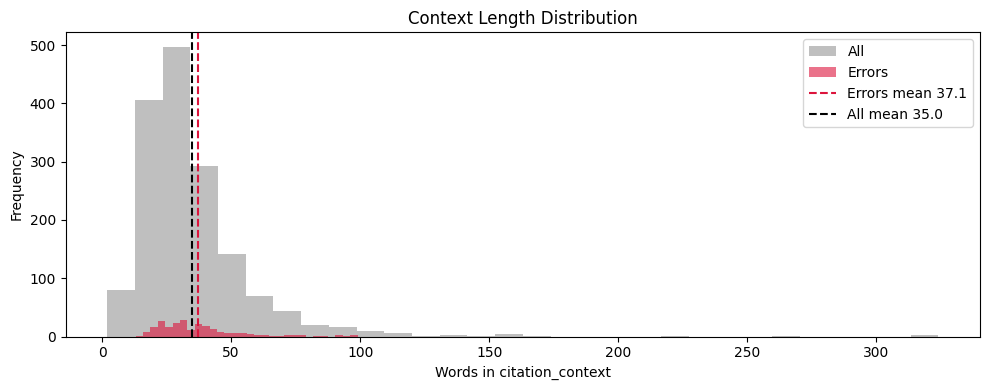

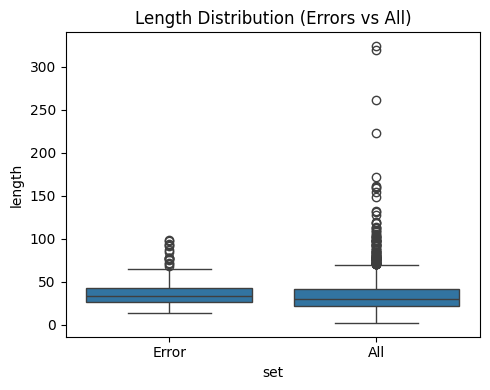


Error distribution by length bin:
  length_bin  error_count        pct
0       <=20           18   7.531381
1      21-40          149  62.343096
2      41-60           54  22.594142
3        >60           18   7.531381


/var/folders/7y/xbhz7zds5_9376q8nwmj0nl80000gn/T/ipykernel_33002/623681206.py:39: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  length_bin_counts = master_errors.groupby('length_bin').size().reset_index(name='error_count')


In [15]:
# Phase 2 Step 3: Sentence Length Impact
# Compute length for all samples for comparison
if 'context_length_words' not in df.columns:
    df['context_length_words'] = df['text'].apply(lambda x: len(str(x).split()))

errors_lengths = master_errors['context_length_words']
all_lengths = df['context_length_words']

print(f"Mean length (errors): {errors_lengths.mean():.2f} words")
print(f"Mean length (all): {all_lengths.mean():.2f} words")

plt.figure(figsize=(10,4))
plt.hist(all_lengths, bins=30, alpha=0.5, label='All', color='gray')
plt.hist(errors_lengths, bins=30, alpha=0.6, label='Errors', color='crimson')
plt.axvline(errors_lengths.mean(), color='crimson', linestyle='--', label=f'Errors mean {errors_lengths.mean():.1f}')
plt.axvline(all_lengths.mean(), color='black', linestyle='--', label=f'All mean {all_lengths.mean():.1f}')
plt.title('Context Length Distribution')
plt.xlabel('Words in citation_context')
plt.ylabel('Frequency')
plt.legend()
plt.tight_layout()
plt.show()

# Boxplot comparison
length_comp = pd.DataFrame({
    'length': pd.concat([errors_lengths, all_lengths], ignore_index=True),
    'set': ['Error']*len(errors_lengths) + ['All']*len(all_lengths)
})
plt.figure(figsize=(5,4))
sns.boxplot(data=length_comp, x='set', y='length')
plt.title('Length Distribution (Errors vs All)')
plt.tight_layout()
plt.show()

# Optional: length bin summary
bins = [0,20,40,60,1e9]
labels = ['<=20','21-40','41-60','>60']
master_errors['length_bin'] = pd.cut(master_errors['context_length_words'], bins=bins, labels=labels)
length_bin_counts = master_errors.groupby('length_bin').size().reset_index(name='error_count')
length_bin_counts['pct'] = length_bin_counts['error_count']/len(master_errors)*100
print('\nError distribution by length bin:')
print(length_bin_counts)

In [17]:
# Phase 2 Quick Quartile Print (No DF Mutation)
# Prints Q1 (25%), Q2 (Median), Q3 (75%), Q4 (Max) for errors vs overall
quartile_points = [0.25, 0.50, 0.75, 1.00]
labels = ['Q1 (25%)', 'Q2 (Median)', 'Q3 (75%)', 'Q4 (Max)']

# Ensure lengths available (recompute silently if not)
if 'errors_lengths' not in globals() or 'all_lengths' not in globals():
    if 'master_errors' not in globals():
        master_errors = errors_df.copy()
    if 'context_length_words' not in df.columns:
        df['context_length_words'] = df['text'].apply(lambda x: len(str(x).split()))
    errors_lengths = master_errors['context_length_words']
    all_lengths = df['context_length_words']

err_qs = errors_lengths.quantile(quartile_points)
all_qs = all_lengths.quantile(quartile_points)

print("Context Length Quartiles (words): Errors vs All")
print("Label        | Errors | All | Diff (Errors-All)")
print("-------------|--------|-----|------------------")
for q, lab in zip(quartile_points, labels):
    e = int(err_qs.loc[q])
    a = int(all_qs.loc[q])
    d = e - a
    print(f"{lab:<12} | {e:>6} | {a:>3} | {d:>+5}")

# Interquartile range comparison
iqr_err = err_qs.loc[0.75] - err_qs.loc[0.25]
iqr_all = all_qs.loc[0.75] - all_qs.loc[0.25]
print(f"\nIQR (Errors): {int(iqr_err)} words | IQR (All): {int(iqr_all)} words | Diff: {int(iqr_err - iqr_all):+d}")


Context Length Quartiles (words): Errors vs All
Label        | Errors | All | Diff (Errors-All)
-------------|--------|-----|------------------
Q1 (25%)     |     26 |  22 |    +4
Q2 (Median)  |     33 |  30 |    +3
Q3 (75%)     |     42 |  41 |    +1
Q4 (Max)     |     99 | 324 |  -225

IQR (Errors): 16 words | IQR (All): 19 words | Diff: -2


In [18]:
# Phase 2 Length Bin Error Rate Analysis (Print Only, No DF Mutation)
# Computes error rate per length bin to normalize raw error counts.

import numpy as np

# Ensure lengths exist
if 'context_length_words' not in df.columns:
    df['context_length_words'] = df['text'].apply(lambda x: len(str(x).split()))

# Define bins & labels consistent with earlier cell
_bins = [0, 20, 40, 60, 1e9]
_labels = ['<=20','21-40','41-60','>60']

# Cut without permanently adding columns (use temporary Series)
all_bins = pd.cut(df['context_length_words'], bins=_bins, labels=_labels)
error_bins = pd.cut(master_errors['context_length_words'], bins=_bins, labels=_labels)

all_counts = all_bins.value_counts().reindex(_labels, fill_value=0)
error_counts = error_bins.value_counts().reindex(_labels, fill_value=0)

# Compute error rate (%). Guard divide-by-zero
error_rate = []
for lbl in _labels:
    total = all_counts.loc[lbl]
    errs = error_counts.loc[lbl]
    rate = (errs / total * 100) if total > 0 else np.nan
    error_rate.append(rate)

length_bin_analysis = pd.DataFrame({
    'length_bin': _labels,
    'total_examples': all_counts.values,
    'error_count': error_counts.values,
    'error_rate_pct': np.round(error_rate, 2)
})

overall_error_rate = len(master_errors) / len(df) * 100

print("Length Bin Error Rate Analysis (Errors normalized by availability)")
print(f"Overall error rate: {overall_error_rate:.2f}%\n")
print("length_bin | total | errors | error_rate_pct | lift_vs_overall")
print("-----------|-------|--------|----------------|----------------")
for _, row in length_bin_analysis.iterrows():
    lift = row['error_rate_pct'] - overall_error_rate if not np.isnan(row['error_rate_pct']) else np.nan
    print(f"{row['length_bin']:<10} | {int(row['total_examples']):>5} | {int(row['error_count']):>6} | {row['error_rate_pct']:>14.2f} | {lift:>+15.2f}")

# Identify bins with above-average error rate
above = length_bin_analysis[length_bin_analysis['error_rate_pct'] > overall_error_rate]
if not above.empty:
    print("\nBins with ABOVE-average error rate:")
    for _, r in above.iterrows():
        print(f" - {r['length_bin']}: {r['error_rate_pct']:.2f}% (lift {r['error_rate_pct'] - overall_error_rate:+.2f} pp)")
else:
    print("\nNo bins exceed overall error rate.")

# Highlight top bin by error rate
top_bin = length_bin_analysis.sort_values('error_rate_pct', ascending=False).iloc[0]
print(f"\nHighest error-rate bin: {top_bin['length_bin']} at {top_bin['error_rate_pct']:.2f}%")


Length Bin Error Rate Analysis (Errors normalized by availability)
Overall error rate: 14.97%

length_bin | total | errors | error_rate_pct | lift_vs_overall
-----------|-------|--------|----------------|----------------
<=20       |   336 |     18 |           5.36 |           -9.61
21-40      |   856 |    149 |          17.41 |           +2.44
41-60      |   268 |     54 |          20.15 |           +5.18
>60        |   136 |     18 |          13.24 |           -1.73

Bins with ABOVE-average error rate:
 - 21-40: 17.41% (lift +2.44 pp)
 - 41-60: 20.15% (lift +5.18 pp)

Highest error-rate bin: 41-60 at 20.15%


Error Count Pivot: document_section × length_bin


/var/folders/7y/xbhz7zds5_9376q8nwmj0nl80000gn/T/ipykernel_33002/3420621938.py:14: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  .pivot_table(index='document_section', columns='length_bin', values='citation_context', aggfunc='count', fill_value=0)


length_bin,<=20,21-40,41-60,>60,Total
document_section,,,,,
Background,10,71,20,9,110
Method,8,61,24,6,99
Weakness/Limitation,0,14,7,3,24
Result/Comparison,0,3,3,0,6



Row-Wise Percentage Pivot (% of a section's errors by length bin)


length_bin,<=20,21-40,41-60,>60
document_section,,,,
Background,9.09,64.55,18.18,8.18
Method,8.08,61.62,24.24,6.06
Weakness/Limitation,0.00,58.33,29.17,12.50
Result/Comparison,0.00,50.00,50.00,0.00



Hotspot Candidates (section, length_bin, pct, type):
 - Background | 21-40 | 64.5% | dominant_bin
 - Method | 21-40 | 61.6% | dominant_bin
 - Weakness/Limitation | 21-40 | 58.3% | dominant_bin
 - Result/Comparison | 21-40 | 50.0% | dominant_bin
 - Result/Comparison | 41-60 | 50.0% | dominant_bin


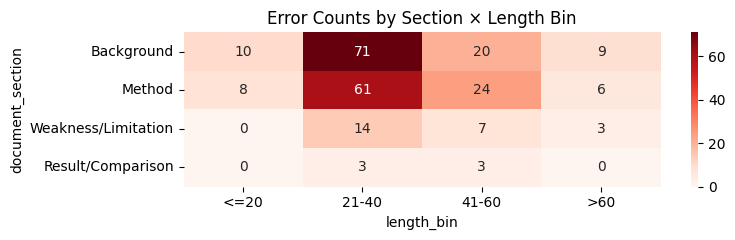

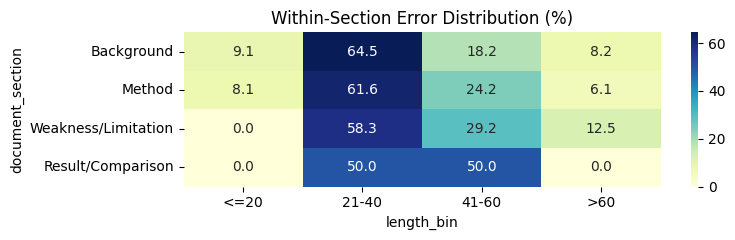

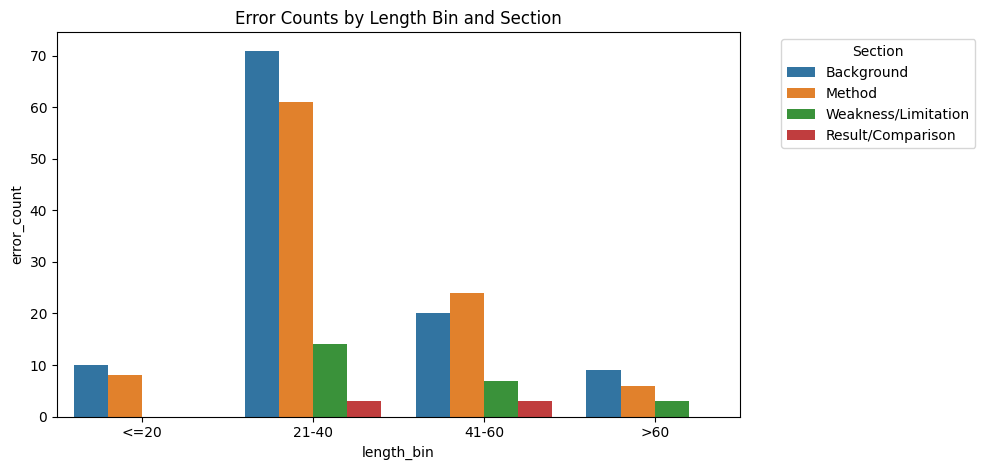


Narrative Summary:
 - Section with most total errors: Background (110 errors)
 - Highest proportion of long-context errors (>60 words): Weakness/Limitation (12.5%)
 - Most common error length bin overall: 21-40 (149 errors)
 - Use row-wise percentages to decide whether a section relies heavily on a specific length band.


In [19]:
# Phase 2 Interaction: Document Section × Length Bin (Error Hotspots)
# Goal: Identify which sections produce disproportionate errors at specific length ranges.
import seaborn as sns
import matplotlib.pyplot as plt

# Ensure length_bin exists (created earlier in Step 3, but guard just in case)
if 'length_bin' not in master_errors.columns:
    _bins = [0,20,40,60,1e9]
    _labels = ['<=20','21-40','41-60','>60']
    master_errors['length_bin'] = pd.cut(master_errors['context_length_words'], bins=_bins, labels=_labels)

# Pivot: counts of errors
count_pivot = (master_errors
               .pivot_table(index='document_section', columns='length_bin', values='citation_context', aggfunc='count', fill_value=0)
               .reindex(columns=['<=20','21-40','41-60','>60']))
count_pivot['Total'] = count_pivot.sum(axis=1)
count_pivot = count_pivot.sort_values('Total', ascending=False)

# Percentage within each section (row-wise)
pct_pivot = (count_pivot.drop(columns=['Total'])
             .div(count_pivot.drop(columns=['Total']).sum(axis=1), axis=0) * 100)

print("Error Count Pivot: document_section × length_bin")
display(count_pivot)
print("\nRow-Wise Percentage Pivot (% of a section's errors by length bin)")
display(pct_pivot.round(2))

# Identify hotspots: sections where a bin contributes >= threshold (e.g., 40%) OR long bin >60 disproportionately high
hotspots = []
for section, row in pct_pivot.iterrows():
    long_pct = row.get('>60', 0)
    dominant_bins = [b for b, v in row.items() if v >= 40]
    if long_pct >= 15:  # heuristic threshold for long-context concern
        hotspots.append((section, '>60', long_pct, 'long_context_cluster'))
    for b in dominant_bins:
        hotspots.append((section, b, row[b], 'dominant_bin'))

if hotspots:
    print("\nHotspot Candidates (section, length_bin, pct, type):")
    for h in sorted(hotspots, key=lambda x: (-x[2], x[0])):
        print(f" - {h[0]} | {h[1]} | {h[2]:.1f}% | {h[3]}")
else:
    print("\nNo standout hotspots by current thresholds.")

# Heatmap: raw counts
plt.figure(figsize=(8, max(2.5, 0.5*len(count_pivot))))
sns.heatmap(count_pivot.drop(columns=['Total']), annot=True, fmt='d', cmap='Reds')
plt.title('Error Counts by Section × Length Bin')
plt.ylabel('document_section')
plt.xlabel('length_bin')
plt.tight_layout()
plt.show()

# Heatmap: percentages
plt.figure(figsize=(8, max(2.5, 0.5*len(pct_pivot))))
sns.heatmap(pct_pivot.round(1), annot=True, fmt='.1f', cmap='YlGnBu')
plt.title('Within-Section Error Distribution (%)')
plt.ylabel('document_section')
plt.xlabel('length_bin')
plt.tight_layout()
plt.show()

# Grouped bar chart for counts
melt_counts = (count_pivot.drop(columns=['Total'])
               .reset_index()
               .melt(id_vars='document_section', var_name='length_bin', value_name='error_count'))
plt.figure(figsize=(10, 4 + 0.2*len(count_pivot)))
sns.barplot(data=melt_counts, x='length_bin', y='error_count', hue='document_section')
plt.title('Error Counts by Length Bin and Section')
plt.xlabel('length_bin')
plt.ylabel('error_count')
plt.legend(title='Section', bbox_to_anchor=(1.05,1), loc='upper left')
plt.tight_layout()
plt.show()

# Brief narrative summary (printed)
print("\nNarrative Summary:")
# Highest total error section
top_section = count_pivot.index[0]
print(f" - Section with most total errors: {top_section} ({count_pivot.loc[top_section, 'Total']} errors)")
# Section where long contexts (>60) most concentrated (by pct)
if '>60' in pct_pivot.columns:
    long_rank = pct_pivot['>60'].sort_values(ascending=False)
    top_long_section = long_rank.index[0]
    print(f" - Highest proportion of long-context errors (>60 words): {top_long_section} ({long_rank.iloc[0]:.1f}%)")
# Most dominant bin overall (sum across sections)
overall_bin_counts = count_pivot.drop(columns=['Total']).sum(axis=0)
dominant_bin = overall_bin_counts.idxmax()
print(f" - Most common error length bin overall: {dominant_bin} ({overall_bin_counts.max()} errors)")
print(" - Use row-wise percentages to decide whether a section relies heavily on a specific length band.")


In [13]:
# Phase 2 Wrap-Up: Master Error Sheet Preview
preview_cols = [
    'citation_context','true_label_verbose','pred_label_verbose','error_type',
    'context_length_words','document_section','cue_hedging','cue_contrastive','cue_positive_eval',
    'cue_negative_eval','cue_metric','cue_multi_citation','intent'
 ]
existing_preview_cols = [c for c in preview_cols if c in master_errors.columns]
print('Preview columns included:', existing_preview_cols)
master_errors[existing_preview_cols].head(10)

Preview columns included: ['citation_context', 'true_label_verbose', 'pred_label_verbose', 'error_type', 'context_length_words', 'document_section', 'cue_hedging', 'cue_contrastive', 'cue_positive_eval', 'cue_negative_eval', 'cue_metric', 'cue_multi_citation', 'intent']


,citation_context,true_label_verbose,pred_label_verbose,error_type,context_length_words,document_section,cue_hedging,cue_contrastive,cue_positive_eval,cue_negative_eval,cue_metric,cue_multi_citation,intent
1,"In Table 6 we report our results, together wit...",neutral,positive,neutral_as_positive,33,Result/Comparison,0,0,1,0,0,0,Result/Comparison
2,"(2006) produced a corpus of 4,000 questions an...",negative,neutral,negative_as_neutral,41,Method,0,0,0,0,1,1,Method
6,"However, these unsupervised methodologies show...",neutral,negative,neutral_as_negative,48,Method,0,1,0,1,1,1,Method
7,2 Previous Work We briefly outline the most im...,neutral,positive,neutral_as_positive,38,Background,0,0,0,0,0,0,Background
20,Among the most widely studied is the Gibbs dis...,neutral,positive,neutral_as_positive,22,Background,0,1,0,0,0,1,Background
27,Although the relative success of previous disa...,positive,negative,positive_as_negative,33,Background,1,1,0,0,0,0,Background
37,They were based on mutual information (Church ...,positive,neutral,positive_as_neutral,31,Background,0,0,0,0,1,1,Background
48,Collocations have been widely used for tasks s...,neutral,positive,neutral_as_positive,27,Background,0,0,0,0,0,1,Background
64,"As expected, we see that MST does better than ...",neutral,negative,neutral_as_negative,21,Result/Comparison,0,0,1,0,1,0,Result/Comparison
78,Our method is a natural extension of those pro...,negative,neutral,negative_as_neutral,28,Method,0,1,0,1,0,1,Method


## 🤔 3. Probing the "Why": Automated Error Analysis (No Manual Tags)

We approximate underlying error causes by surfacing lexical & phrasal patterns that are disproportionately frequent in misclassified citation contexts.

### Method A: N-gram (Bigram + Trigram) Enrichment

Steps:
1. Split dataset into correctly classified vs misclassified (errors) citation contexts.
2. Extract bigrams and trigrams with a `CountVectorizer` (stopword-filtered, min frequency threshold).
3. For every n-gram, compute:
   - Raw counts in errors and correct sets.
   - Normalized frequency (per 1K texts) in each set.
   - Log2 enrichment = log2( (error_freq + s) / (correct_freq + s) ) with smoothing `s=0.5`.
4. Rank by enrichment to highlight patterns over-represented in errors.
5. Provide separate ranked tables for bigrams and trigrams + examples retrieval helper.
6. (Optional) Invert ranking to see protective n-grams (more common in correct cases).

Interpretation Tips:
- High-enrichment contrastive markers (e.g., *"in contrast"*, *"however ,"*) → model struggles with polarity shifts.
- Negation / limitation phrases (*"fails to"*, *"does not"*) overrepresented → polarity detection weakness.
- Comparative superiority phrases (*"better than"*, *"outperforms"*) enriched in certain mislabel directions → confusion between positive vs neutral.
- Method phrases (*"we use"*, *"we apply"*) enriched may indicate procedural description being mis-read as evaluative.

Next Extensions (if desired):
- POS pattern enrichment (e.g., dependency-based negation).
- Cue-specific masking ablation (replace contrastive tokens to test sensitivity).
- Feed enriched n-grams as features into a lightweight interpretable error classifier to quantify predictive power.


In [20]:
# Automated N-gram Enrichment: Errors vs Correct
from sklearn.feature_extraction.text import CountVectorizer
import pandas as pd
import numpy as np
import math

# Prepare corpora
all_df = df.copy()
all_df['is_error'] = (all_df['label'] != all_df['predicted_label']).astype(int)
errors_corpus = all_df[all_df['is_error']==1]['text'].fillna('').tolist()
correct_corpus = all_df[all_df['is_error']==0]['text'].fillna('').tolist()

print(f"Corpus sizes -> Errors: {len(errors_corpus)} | Correct: {len(correct_corpus)}")

if len(errors_corpus) == 0 or len(correct_corpus) == 0:
    raise ValueError("Need both error and correct sets for enrichment analysis.")

# Vectorizer configs
stop_words = 'english'
min_df_bigram = 2  # adjust if corpus small
min_df_trigram = 2

vectorizers = {
    'bigram': CountVectorizer(ngram_range=(2,2), stop_words=stop_words, min_df=min_df_bigram),
    'trigram': CountVectorizer(ngram_range=(3,3), stop_words=stop_words, min_df=min_df_trigram)
}

results = {}
for ngram_label, vect in vectorizers.items():
    # Fit on combined to align vocabulary
    combined_corpus = errors_corpus + correct_corpus
    vect.fit(combined_corpus)
    vocab = vect.get_feature_names_out()

    err_mat = vect.transform(errors_corpus)
    cor_mat = vect.transform(correct_corpus)

    err_counts = np.asarray(err_mat.sum(axis=0)).flatten()
    cor_counts = np.asarray(cor_mat.sum(axis=0)).flatten()

    # Normalized frequency per 1000 texts
    err_freq = err_counts / max(1,len(errors_corpus)) * 1000
    cor_freq = cor_counts / max(1,len(correct_corpus)) * 1000

    # Smoothing & enrichment log2((err+s)/(cor+s))
    s = 0.5
    enrichment = np.log2((err_freq + s) / (cor_freq + s))

    df_ngrams = pd.DataFrame({
        'ngram': vocab,
        'error_count': err_counts,
        'correct_count': cor_counts,
        'error_freq_per_1k': err_freq,
        'correct_freq_per_1k': cor_freq,
        'log2_enrichment': enrichment
    })

    # Filter low-support n-grams (both groups total < 3 occurrences)
    df_ngrams = df_ngrams[(df_ngrams['error_count'] + df_ngrams['correct_count']) >= 3]

    # Sort by enrichment desc
    df_sorted = df_ngrams.sort_values('log2_enrichment', ascending=False)
    results[ngram_label] = df_sorted

    print(f"\nTop {ngram_label} n-grams enriched in errors (log2_enrichment desc):")
    display(df_sorted.head(15)[['ngram','error_count','correct_count','error_freq_per_1k','correct_freq_per_1k','log2_enrichment']])

    print(f"\nTop {ngram_label} n-grams more common in correct cases (potentially protective):")
    display(df_sorted.sort_values('log2_enrichment', ascending=True).head(10)[['ngram','error_count','correct_count','error_freq_per_1k','correct_freq_per_1k','log2_enrichment']])

# Helper: retrieve contexts containing a given n-gram (prioritize errors)
def find_examples(ngram, n=5, error_first=True):
    ngram_lc = ngram.lower()
    if error_first:
        err_matches = all_df[all_df['is_error']==1 & all_df['text'].str.lower().str.contains(ngram_lc)]
        cor_matches = all_df[all_df['is_error']==0 & all_df['text'].str.lower().str.contains(ngram_lc)]
        return pd.concat([err_matches.head(n), cor_matches.head(max(0,n-len(err_matches.head(n))))])[
            ['text','label','predicted_label','is_error']
        ]
    else:
        matches = all_df[all_df['text'].str.lower().str.contains(ngram_lc)]
        return matches.head(n)[['text','label','predicted_label','is_error']]

print("\nRun find_examples('in contrast', n=3) after this cell (adjust phrase) for qualitative inspection.")


Corpus sizes -> Errors: 239 | Correct: 1357

Top bigram n-grams enriched in errors (log2_enrichment desc):


,ngram,error_count,correct_count,error_freq_per_1k,correct_freq_per_1k,log2_enrichment
1675,opinion mining,5,0,20.920502,0.00000,5.420920
861,dredze et,3,0,12.552301,0.00000,4.706232
2606,word gram,3,0,12.552301,0.00000,4.706232
2319,text summarization,3,0,12.552301,0.00000,4.706232
908,error reduction,3,0,12.552301,0.00000,4.706232
534,bharati et,3,0,12.552301,0.00000,4.706232
920,european languages,3,0,12.552301,0.00000,4.706232
1690,overlapping features,3,0,12.552301,0.00000,4.706232
1899,ramage 2007,3,1,12.552301,0.73692,3.399480
678,collins duffy,3,1,12.552301,0.73692,3.399480



Top bigram n-grams more common in correct cases (potentially protective):


,ngram,error_count,correct_count,error_freq_per_1k,correct_freq_per_1k,log2_enrichment
548,bleu score,0,23,0.0,16.949153,-5.125085
1053,giza och,0,17,0.0,12.527634,-4.703503
788,della pietra,0,17,0.0,12.527634,-4.703503
384,alignment model,0,14,0.0,10.316875,-4.435212
1814,pos tagging,0,14,0.0,10.316875,-4.435212
975,feature weights,0,14,0.0,10.316875,-4.435212
1207,inversion transduction,0,12,0.0,8.843036,-4.223891
1346,likelihood ratio,0,12,0.0,8.843036,-4.223891
1305,learning algorithm,0,12,0.0,8.843036,-4.223891
2021,score papineni,0,12,0.0,8.843036,-4.223891



Top trigram n-grams enriched in errors (log2_enrichment desc):


,ngram,error_count,correct_count,error_freq_per_1k,correct_freq_per_1k,log2_enrichment
349,bharati et al,3,0,12.552301,0.00000,4.706232
508,dredze et al,3,0,12.552301,0.00000,4.706232
1128,riezler et al,3,1,12.552301,0.73692,3.399480
674,hughes ramage 2007,3,1,12.552301,0.73692,3.399480
538,erkan radev 2004,3,1,12.552301,0.73692,3.399480
896,mihalcea tarau 2004,2,1,8.368201,0.73692,2.841890
1330,use statistical methods,2,1,8.368201,0.73692,2.841890
398,chunking ramshaw marcus,2,1,8.368201,0.73692,2.841890
402,church hanks 1989,2,1,8.368201,0.73692,2.841890
941,murray et al,2,1,8.368201,0.73692,2.841890



Top trigram n-grams more common in correct cases (potentially protective):


,ngram,error_count,correct_count,error_freq_per_1k,correct_freq_per_1k,log2_enrichment
627,giza och ney,0,15,0.0,11.053795,-4.530295
1147,score papineni et,0,12,0.0,8.843036,-4.223891
858,maximum entropy model,0,12,0.0,8.843036,-4.223891
356,bleu score papineni,0,12,0.0,8.843036,-4.223891
876,mert och 2003,0,10,0.0,7.369197,-3.976216
793,liang et al,0,10,0.0,7.369197,-3.976216
889,metric papineni et,0,10,0.0,7.369197,-3.976216
479,described brown et,0,10,0.0,7.369197,-3.976216
1092,rate training mert,0,8,0.0,5.895357,-3.677025
748,klein manning 2002,0,8,0.0,5.895357,-3.677025



Run find_examples('in contrast', n=3) after this cell (adjust phrase) for qualitative inspection.


In [21]:
# Subgroup Pivot & Exhaustive Error Listing
# Subgroups defined as: (error_type, intent, cue_signature)
# cue_signature is a compact string of active cue flags (contrastive, hedging, positive_eval, negative_eval, metric, multi_citation)

from IPython.display import display

# Work on a copy to avoid mutating earlier analyses
sub_errors = master_errors.copy()

cue_cols = [c for c in ['cue_contrastive','cue_hedging','cue_positive_eval','cue_negative_eval','cue_metric','cue_multi_citation'] if c in sub_errors.columns]

def build_cue_signature(row):
    active = []
    for c in cue_cols:
        if row.get(c, 0) == 1:
            # shorten names
            short = c.replace('cue_','')
            active.append(short)
    return '+'.join(active) if active else 'no_cues'

sub_errors['cue_signature'] = sub_errors.apply(build_cue_signature, axis=1)

# Create subgroup key for clarity (optional)
sub_errors['subgroup_key'] = sub_errors['error_type'] + ' | ' + sub_errors['intent'] + ' | ' + sub_errors['cue_signature']

# Pivot table (counts)
subgroup_counts = (sub_errors
                   .groupby(['error_type','intent','cue_signature'])
                   .size()
                   .reset_index(name='error_count')
                   .sort_values('error_count', ascending=False))

print('Subgroup Pivot (error_type × intent × cue_signature):')
display(subgroup_counts.head(25))
print(f"Total distinct subgroups: {len(subgroup_counts)}\n")

# Optional: also provide a simple wide pivot (error_type vs intent) ignoring cues
simple_pivot = (sub_errors
                .groupby(['error_type','intent'])
                .size()
                .reset_index(name='count')
                .pivot(index='error_type', columns='intent', values='count')
                .fillna(0)
               )
print('Simple Pivot (error_type × intent):')
display(simple_pivot)

# Iterate over subgroups descending by count and print all examples
# WARNING: This may produce a lot of output; adjust MAX_GROUPS or MAX_PER_GROUP to limit.
MAX_GROUPS = None   # set to an int to restrict number of subgroups printed
MAX_PER_GROUP = None  # set to an int to truncate per subgroup

print('\n==== FULL ERROR LISTING BY SUBGROUP (Descending Count) ====')
for idx, row in enumerate(subgroup_counts.itertuples(index=False)):
    if MAX_GROUPS is not None and idx >= MAX_GROUPS:
        print(f"\n[Truncated output after {MAX_GROUPS} subgroups]")
        break
    etype = row.error_type
    intent = row.intent
    cuesig = row.cue_signature
    group_df = sub_errors[(sub_errors['error_type']==etype) & (sub_errors['intent']==intent) & (sub_errors['cue_signature']==cuesig)]
    if MAX_PER_GROUP is not None:
        group_df = group_df.head(MAX_PER_GROUP)
    print(f"\n--- Subgroup #{idx+1} ---")
    print(f"error_type: {etype}")
    print(f"intent: {intent}")
    print(f"cue_signature: {cuesig}")
    print(f"errors_in_subgroup: {len(group_df)}")
    print('-'*60)
    for j, r in enumerate(group_df.itertuples(index=False)):
        print(f"[Example {j+1}] true={r.true_label_verbose} pred={r.pred_label_verbose}")
        print(r.citation_context)
        print()
print('\nDone.')


Subgroup Pivot (error_type × intent × cue_signature):


,error_type,intent,cue_signature,error_count
65,neutral_as_positive,Background,multi_citation,12
77,neutral_as_positive,Method,metric+multi_citation,12
66,neutral_as_positive,Background,no_cues,10
78,neutral_as_positive,Method,multi_citation,9
64,neutral_as_positive,Background,metric+multi_citation,9
124,positive_as_neutral,Method,no_cues,6
24,neutral_as_negative,Background,contrastive+metric+multi_citation,5
63,neutral_as_positive,Background,metric,5
113,positive_as_neutral,Background,no_cues,5
111,positive_as_neutral,Background,metric+multi_citation,4


Total distinct subgroups: 130

Simple Pivot (error_type × intent):


intent,Background,Method,Result/Comparison,Weakness/Limitation
error_type,,,,
negative_as_neutral,4.0,11.0,0.0,2.0
negative_as_positive,2.0,3.0,0.0,0.0
neutral_as_negative,27.0,20.0,2.0,9.0
neutral_as_positive,46.0,41.0,2.0,9.0
positive_as_negative,6.0,6.0,0.0,1.0
positive_as_neutral,25.0,18.0,2.0,3.0



==== FULL ERROR LISTING BY SUBGROUP (Descending Count) ====

--- Subgroup #1 ---
error_type: neutral_as_positive
intent: Background
cue_signature: multi_citation
errors_in_subgroup: 12
------------------------------------------------------------
[Example 1] true=neutral pred=positive
Collocations have been widely used for tasks such as word sense disambiguation (WSD) (Yarowsky, 1995), information extraction (IE) (Riloff, 1996), and named-entity recognition (Collins and Singer, 1999)

[Example 2] true=neutral pred=positive
6 Related Work The most relevant previous works include word sense translation and translation disambiguation (Li & Li 2003; Cao & Li 2002; Koehn and Knight 2000; Kikui 1999; Fung et al. , 1999), frame semantic induction (Green et al. , 2004; Fung & Chen 2004), and bilingual semantic mapping (Fung & Chen 2004; Huang et al. 2004; Ploux & Ji, 2003, Ngai et al. , 2002; Palmer & Wu 1995)

[Example 3] true=neutral pred=positive
2 Related Work The most commonly used simila

In [22]:
# Sample Examples by Length Category (Errors vs Correct)
# Categories: short (<=20 words), medium (21-40), long (>40)
# Adjust NUM_SAMPLES to change how many examples per (category, correctness) pair.

NUM_SAMPLES = 3

# Ensure base length column exists for full df
if 'context_length_words' not in df.columns:
    df['context_length_words'] = df['text'].apply(lambda x: len(str(x).split()))

# Prepare correct subset
correct_df = df[df['label'] == df['predicted_label']].copy()

# Helper to assign category
def length_cat(n):
    if n <= 20:
        return 'short'
    elif n <= 40:
        return 'medium'
    else:
        return 'long'

# Add category columns (avoid overwriting if already exist with same logic)
master_errors['length_category'] = master_errors['context_length_words'].apply(length_cat)
correct_df['length_category'] = correct_df['context_length_words'].apply(length_cat)

categories = ['short','medium','long']

print("=== Sample Examples by Length Category ===")
for cat in categories:
    print(f"\n### Category: {cat.upper()}\n")
    # Errors
    err_subset = master_errors[master_errors['length_category']==cat].copy()
    if not err_subset.empty:
        print(f"-- Errors (n={len(err_subset)}) --")
        for i, row in err_subset.head(NUM_SAMPLES).iterrows():
            cue_list = [c.replace('cue_','') for c in ['cue_contrastive','cue_hedging','cue_positive_eval','cue_negative_eval','cue_metric','cue_multi_citation'] if c in row.index and row[c]==1]
            print(f"[Error {i}] true={row['true_label_verbose']} pred={row['pred_label_verbose']} len={row['context_length_words']} intent={row.get('intent','')} cues={','.join(cue_list) if cue_list else 'none'}")
            print(row['citation_context'])
            print()
    else:
        print("-- Errors: None --\n")

    # Correct
    cor_subset = correct_df[correct_df['length_category']==cat].copy()
    if not cor_subset.empty:
        print(f"-- Correct (n={len(cor_subset)}) --")
        for i, row in cor_subset.head(NUM_SAMPLES).iterrows():
            print(f"[Correct {i}] label={row['label']} len={row['context_length_words']}")
            print(row['text'])
            print()
    else:
        print("-- Correct: None --")

print("\nDone sampling examples. Adjust NUM_SAMPLES or category thresholds as needed.")

=== Sample Examples by Length Category ===

### Category: SHORT

-- Errors (n=18) --
[Error 81] true=neutral pred=positive len=18 intent=Background cues=none
(Yarowsky, 1995) reports a success rate of 96% disambiguating twelve words with two clear sense distinctions each one)

[Error 99] true=neutral pred=positive len=20 intent=Background cues=metric
This corpus-based information typically concerns sequences of 1-3 tags or words (with some well-known exceptions, e.g. Cutting et al. 1992)

[Error 379] true=positive pred=neutral len=17 intent=Background cues=metric,multi_citation
Unlike Choueka (1988), Church and Hanks (1990) identify as collocations both interrupted and uninterrupted sequences of words

-- Correct (n=318) --
[Correct 21] label=o len=15
For a detailed introduction to IBM translation models, please see (Brown et al. , 1993)

[Correct 25] label=o len=15
al. 2003b) 147 is (B)eginning, (I)nside or (O)utside of a chunk (Ramshaw & Marcus, 1995)

[Correct 26] label=o len=8
arpu

### Case Study

Accuracy by Intent (Descending):
             intent  total  errors accuracy
         Background    825     110    86.67
             Method    702      99    85.90
  Result/Comparison     17       6    64.71
Weakness/Limitation     52      24    53.85

Best intent: Background accuracy=86.67% (errors=110/825)
Worst intent: Weakness/Limitation accuracy=53.85% (errors=24/52)


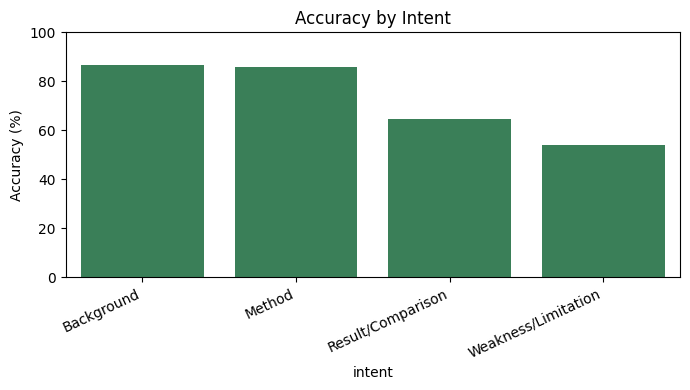

In [23]:
# Accuracy by Intent / Document Section
# Uses rule-based classify_intent already defined earlier for errors; re-apply to full df for completeness.

# 1. Ensure intent for full dataset
if 'intent' not in df.columns:
    # Reuse classify_intent defined earlier (assumes it's still in memory). If not, redefine quickly.
    try:
        classify_intent
    except NameError:
        intent_patterns = {
            'Background': ['previous work','prior work','earlier work','as described','as discussed','related work','see also','following','based on','according to'],
            'Method': ['we use','we adopt','we apply','we employ','using the','using a','method','approach','model','framework','algorithm'],
            'Result/Comparison': ['outperforms','better than','compared to','versus','state-of-the-art','competitive','achieves','higher than','lower than','improves over'],
            'Weakness/Limitation': ['fails','limitation','drawback','weakness','cannot','unable','insufficient','problem','issue','challenge'],
            'Other': []
        }
        def classify_intent(text):
            tl = str(text).lower()
            scores = {k:0 for k in intent_patterns}
            for intent, pats in intent_patterns.items():
                for p in pats:
                    if p in tl:
                        scores[intent] += 1
            best_intent = max(scores.items(), key=lambda kv: kv[1])[0]
            if scores[best_intent] == 0:
                return 'Background'
            return best_intent
    df['intent'] = df['text'].apply(classify_intent)

# 2. Compute per-intent counts
intent_stats = (df
    .assign(is_error=lambda x: (x['label'] != x['predicted_label']).astype(int))
    .groupby('intent')
    .agg(total=('label','count'), errors=('is_error','sum'))
    .reset_index())
intent_stats['accuracy'] = (intent_stats['total'] - intent_stats['errors']) / intent_stats['total'] * 100
intent_stats = intent_stats.sort_values('accuracy', ascending=False)

print("Accuracy by Intent (Descending):")
print(intent_stats.to_string(index=False, formatters={'accuracy':lambda v: f"{v:.2f}"}))

# Highlight lowest and highest
best = intent_stats.iloc[0]
worst = intent_stats.iloc[-1]
print(f"\nBest intent: {best.intent} accuracy={best.accuracy:.2f}% (errors={best.errors}/{best.total})")
print(f"Worst intent: {worst.intent} accuracy={worst.accuracy:.2f}% (errors={worst.errors}/{worst.total})")

# Optional: bar plot
import seaborn as sns, matplotlib.pyplot as plt
plt.figure(figsize=(7,4))
sns.barplot(data=intent_stats, x='intent', y='accuracy', color='seagreen')
plt.xticks(rotation=25, ha='right')
plt.ylabel('Accuracy (%)')
plt.title('Accuracy by Intent')
plt.ylim(0,100)
plt.tight_layout()
plt.show()

### Intent Accuracy & Long-Context Misclassification Analysis
The following cells compute:
1. Accuracy by intent (document_section) across the full dataset.
2. Long citation (>60 words) misclassification concentration by section and relative lift.

Overall long-context (>60) error rate: 13.24% (n=136)

Long Context Misclassification by Intent (sorted by long_error_rate):
             intent  long_total  long_errors long_error_rate long_error_rate_lift_vs_overall_long long_context_share_of_section section_error_rate
Weakness/Limitation         6.0          3.0           50.00                               +36.76                         11.54              46.15
         Background        60.0          9.0           15.00                                +1.76                          7.27              13.33
             Method        70.0          6.0            8.57                                -4.66                          9.97              14.10
  Result/Comparison         0.0          0.0             NaN                                  NaN                          0.00              35.29

No sections exceed both long-share and lift thresholds.


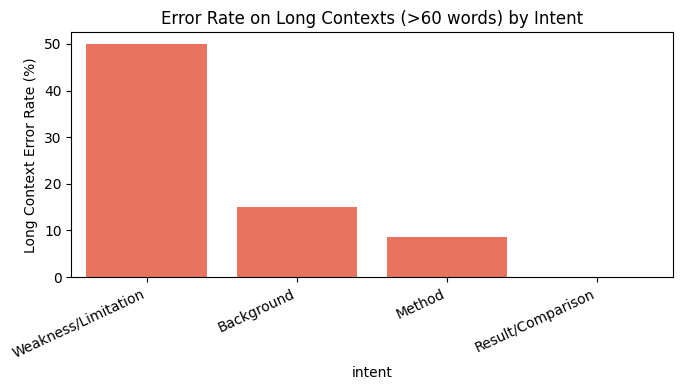

In [24]:
# Long Citation Misclassification Concentration by Section / Intent
# Define long as >60 words (consistent with earlier length bins labeling >60)

# Ensure length column exists
if 'context_length_words' not in df.columns:
    df['context_length_words'] = df['text'].apply(lambda x: len(str(x).split()))

# Ensure intent exists (reuse from previous cell if present)
if 'intent' not in df.columns:
    try:
        classify_intent
    except NameError:
        intent_patterns = {
            'Background': ['previous work','prior work','earlier work','as described','as discussed','related work','see also','following','based on','according to'],
            'Method': ['we use','we adopt','we apply','we employ','using the','using a','method','approach','model','framework','algorithm'],
            'Result/Comparison': ['outperforms','better than','compared to','versus','state-of-the-art','competitive','achieves','higher than','lower than','improves over'],
            'Weakness/Limitation': ['fails','limitation','drawback','weakness','cannot','unable','insufficient','problem','issue','challenge'],
            'Other': []
        }
        def classify_intent(text):
            tl = str(text).lower()
            scores = {k:0 for k in intent_patterns}
            for intent, pats in intent_patterns.items():
                for p in pats:
                    if p in tl:
                        scores[intent] += 1
            best_intent = max(scores.items(), key=lambda kv: kv[1])[0]
            if scores[best_intent] == 0:
                return 'Background'
            return best_intent
    df['intent'] = df['text'].apply(classify_intent)

# Add length_bin classification consistent with earlier thresholds for entire df (temp only)
_bins = [0,20,40,60,1e9]
_labels = ['<=20','21-40','41-60','>60']
all_length_bins = pd.cut(df['context_length_words'], bins=_bins, labels=_labels)

df_eval = df.copy()
df_eval['length_bin'] = all_length_bins
df_eval['is_error'] = (df_eval['label'] != df_eval['predicted_label']).astype(int)

# Overall long-context error rate
overall_long = df_eval[df_eval['length_bin']=='>60']
overall_long_error_rate = overall_long['is_error'].mean() * 100 if len(overall_long) else float('nan')
print(f"Overall long-context (>60) error rate: {overall_long_error_rate:.2f}% (n={len(overall_long)})")

# Per intent long-context share & error rate
intent_long_stats = (df_eval[df_eval['length_bin']=='>60']
    .groupby('intent')
    .agg(long_total=('label','count'), long_errors=('is_error','sum'))
    .reset_index())
intent_total_stats = (df_eval
    .groupby('intent')
    .agg(total=('label','count'), total_errors=('is_error','sum'))
    .reset_index())

merged = intent_total_stats.merge(intent_long_stats, on='intent', how='left')
merged[['long_total','long_errors']] = merged[['long_total','long_errors']].fillna(0)
merged['long_error_rate'] = merged.apply(lambda r: (r['long_errors']/r['long_total']*100) if r['long_total']>0 else float('nan'), axis=1)
merged['section_error_rate'] = (merged['total_errors']/merged['total']*100)
merged['long_context_share_of_section'] = merged['long_total']/merged['total']*100
merged['long_error_rate_lift_vs_overall_long'] = merged['long_error_rate'] - overall_long_error_rate

# Sort by long_error_rate descending for visibility
merged = merged.sort_values('long_error_rate', ascending=False)

print("\nLong Context Misclassification by Intent (sorted by long_error_rate):")
print(merged[['intent','long_total','long_errors','long_error_rate','long_error_rate_lift_vs_overall_long','long_context_share_of_section','section_error_rate']]
      .to_string(index=False, formatters={
          'long_error_rate':lambda v: f"{v:.2f}" if pd.notnull(v) else 'NA',
          'long_error_rate_lift_vs_overall_long':lambda v: f"{v:+.2f}" if pd.notnull(v) else 'NA',
          'long_context_share_of_section':lambda v: f"{v:.2f}",
          'section_error_rate':lambda v: f"{v:.2f}"
      }))

# Identify intents that are both long-heavy and high long-error rate
threshold_long_share = 20  # % of that intent's examples that are long
threshold_lift = 5         # percentage points above overall long error rate
risk_sections = merged[(merged['long_context_share_of_section'] >= threshold_long_share) & (merged['long_error_rate_lift_vs_overall_long'] >= threshold_lift)]
if not risk_sections.empty:
    print("\nHigh-Risk Sections (long-heavy AND elevated long error rate):")
    for _, r in risk_sections.iterrows():
        print(f" - {r['intent']}: long_error_rate={r['long_error_rate']:.2f}% (lift {r['long_error_rate_lift_vs_overall_long']:+.2f} pp), long_share={r['long_context_share_of_section']:.1f}%")
else:
    print("\nNo sections exceed both long-share and lift thresholds.")

# Optional barplot of long_error_rate
import seaborn as sns, matplotlib.pyplot as plt
plt.figure(figsize=(7,4))
sns.barplot(data=merged, x='intent', y='long_error_rate', color='tomato')
plt.xticks(rotation=25, ha='right')
plt.ylabel('Long Context Error Rate (%)')
plt.title('Error Rate on Long Contexts (>60 words) by Intent')
plt.tight_layout()
plt.show()

# Clean temporary variables (optional)
del df_eval